In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

Suggestion: try PLA on this dataset before using the bank dataset

In [8]:
#X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
X, y = make_blobs(n_samples=80, centers=2, n_features=2)
#X, y = make_moons(n_samples=1000, noise=0.15)
y = [yy if yy == 1 else -1 for yy in y] 

In [9]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [10]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [11]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    # MPP return [pointOnBoundary(x_min), pointOnBoundary(x_max)]
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [65]:
def pla(training_in, training_out, weights, max_iterations=100):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        iterations+=1;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)[0]!=y):
                #iterations+=1;
                # MPP weights = weights + y*(np.concatenate((bias,x)))
                weights = (weights.T + y*(np.concatenate((bias,x)))).T
                errors+=1;
                     
        if (errors == 0):
            break
            
        # If results are not converging after maximum iterations are reached, exit
        if (iterations==max_iterations):
            break
            
    return weights, iterations

In [24]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

#### Additional Helper Functions

In [58]:
def print_dataset(X, y):
    # Plot the dataset
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    plt.show() 

In [60]:
def plot_data_w_boundary(X, y, weights):
    # Print the data with a line representing the decision boundary
    y_bound = np.zeros([2])
    X_bound = np.zeros([2])
    
    # Get min and max X Coordinate in the Data Set    
    X_bound[0] = X[:,0].min()
    X_bound[1] = X[:,0].max()

    # Get the Y coordinates for min and max X
    y_bound[0], y_bound[1] = decision_boundary(weights, X_bound[0], X_bound[1])
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset with Decision Boundary")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    # Plot Decision Boundary
    plt.plot(X_bound, y_bound, linestyle='dashed', color='black')
    
    plt.show() 

In [61]:
def run_pla(X, y, verbose=1):
    # Run PLA on dataet and display results
    
    # Create and initialize weights
    weights = np.zeros([X.shape[1]+1,1])
    # Set Bias to 1
    weights[0] = 1
    
    weights, iterations = pla(X, y, weights)
    
    plot_data_w_boundary(X, y, weights)
    
    if(verbose==1):
        print("Number of Iterations:      \t",iterations)
        print("Number of Training Samples:\t",X.shape[0])
        print("Calculation Error:         \t",calc_error(X, y, weights))
    
    return weights, iterations

## Blob Dataset

Based on suggestion, using Blob datset for initial experimentation

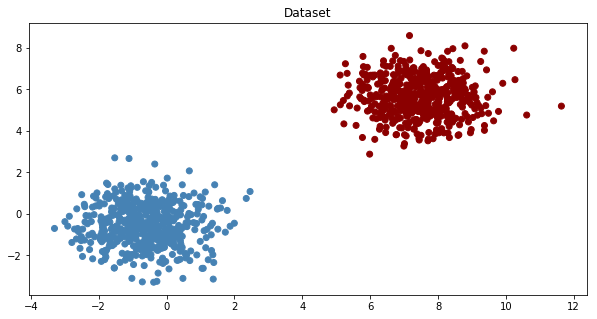

In [66]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)

y = [yy if yy == 1 else -1 for yy in y] 

print_dataset(X, y)

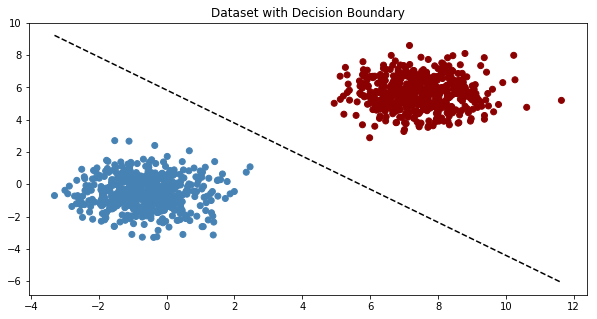

Number of Iterations:      	 2
Number of Training Samples:	 1000
Calculation Error:         	 0.0


In [67]:
run_pla(X,y);

## Moons Dataset

Moons dataset is not linearly separable.
Running similar procedure to Blobs datset to show impact to PLA when not using linearly separable data

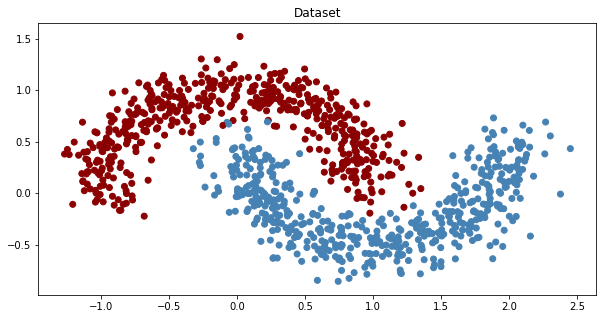

In [68]:
X, y = make_moons(n_samples=1000, noise=0.15)

y = [yy if yy == 1 else -1 for yy in y]

print_dataset(X, y)

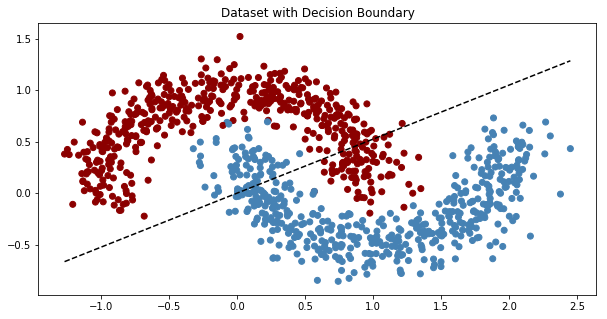

Number of Iterations:      	 100
Number of Training Samples:	 1000
Calculation Error:         	 0.147


In [69]:
run_pla(X,y);